# Object Detection with Faster RCNN (Bone Fraction detection)


In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mykey")
project = rf.workspace("fracture-uofxm").project("bone-fracture-detection-ivsy6")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
loading Roboflow workspace...
loading Roboflow proje


Extracting Dataset Version Zip to Bone-fracture-detection-1 in coco:: 100%|██████████| 1044/1044 [00:00<00:00, 8540.30it/s]


In [2]:
!pip install tqdm

In [3]:
import torch 
import torch.nn as nn 
import torchvision 
from torch.utils.data import DataLoader , Dataset , sampler , random_split
from torch.nn import functional as F
import copy 
import math
from torchvision import datasets , models 
from torchvision.transforms import transforms 
from torchvision.transforms import functional as FT
from torchvision.utils import draw_bounding_boxes as draw
from torch import optim

import albumentations as A # for img augmentation 
from albumentations.pytorch import ToTensorV2 

from tqdm import tqdm
import time
import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw
import seaborn as sns 
import os 
import warnings 
import json
warnings.filterwarnings("ignore")

plt.style.use('dark_background')

In [4]:
# download pycocotools package to deal with our data 
!pip install pycocotools 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.5 MB/s eta 0:00:00a 0:00:01


In [5]:
from pycocotools.coco import COCO

* ## **Global configurations :**

In [6]:
config = {
    "BATCH_SIZE": 16 * torch.cuda.device_count() if torch.cuda.is_available() else 16,
    "LR": 1e-3,
    "DEVICE": 'cuda' if torch.cuda.is_available() else 'cpu', 
}

* ***Explore our data :***

In [7]:
train_path = "/kaggle/working/Bone-fracture-detection-1/train"
test_path = "/kaggle/working/Bone-fracture-detection-1/test"
valid_path = "/kaggle/working/Bone-fracture-detection-1/valid"

In [8]:
json_file_train = [item  for item in os.listdir(train_path) if str(item).split('.')[-1] == 'json']
json_file_test = [item  for item in os.listdir(test_path) if str(item).split('.')[-1] == 'json']
json_file_valid = [item  for item in os.listdir(valid_path) if str(item).split('.')[-1] == 'json']

In [9]:
def load_json(json_path) : 
    f = open(json_path ,)
    return json.load(f)

train_json = load_json(os.path.join(train_path , json_file_train[0]))
valid_json = load_json(os.path.join(valid_path , json_file_valid[0]))
test_json = load_json(os.path.join(test_path , json_file_test[0]))

In [10]:
train_json.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [11]:
total_train_images = len(train_json["images"])
non_empty_images = len(train_json["annotations"])
print(f" number of train images is {total_train_images} image and number of non fracture images is {non_empty_images} image")

 number of train images is 781 image and number of non fracture images is 940 image


In [12]:
classes = [x['name'] for x in train_json['categories']]
classes

['Fracture', 'Fracture']

In [13]:
# Example code
img_id = train_json["annotations"][70]["image_id"]
bbox = train_json['annotations'][70]["bbox"]
target_img = None

# Find the corresponding image
for img in train_json["images"]:
    if img["id"] == img_id:
        target_img = img
        break

# Load and process the image
if target_img is not None:
    image_path = os.path.join(train_path, target_img["file_name"])
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Bounding box coordinates in COCO format
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height

    # Define the bounding box to draw
    bbox_to_draw = [x_min, y_min, x_max, y_max]

    # Draw the bounding box on the image
    draw.rectangle(bbox_to_draw, outline="red", width=3)

    # Save the image with the drawn bounding boxes
    image.save("annotated70.jpg")

In [ ]:
img = Image.open(os.path.join("/kaggle/working/" , 'annotated70.jpg'))
plt.imshow(img)
plt.axis('off')

(-0.5, 349.5, 349.5, -0.5)

* ***Data Loader : ....***

In [ ]:
from torchvision.transforms import v2 as T
def getTransforms(train=False):
    if train:
        transform = T.Compose([
            T.ColorJitter(contrast=0.5),
            T.RandomRotation(30),
            T.CenterCrop(480),
            T.ToTensor()
        ])
    else:
        transform = T.Compose([
            T.ToTensor()
        ])
    return transform

In [ ]:
from torchvision import datasets
import cv2
class BoneFracture(datasets.VisionDataset):
    def __init__(self, root, json_file, target_transform=None, transforms=None, transform=None):
        super().__init__(root, transforms, transform, target_transform)
        self.coco = COCO(os.path.join(root, json_file))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if len(self._load_target(id)) > 0]
        self.root = root

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int):
        id = self.ids[index]
        image = self._load_image(id)
        target = copy.deepcopy(self._load_target(id))
        height, width = image.shape[:2]
        boxes = [t['bbox'] + [t['category_id']] for t in target]  # xywh + category_id
        
        if self.transforms is not None:
            image, boxes = self.transforms(image,boxes)
        
        # Convert boxes from xywh to xyxy
        new_boxes = []
        for box in boxes:
            xmin, ymin, width, height = box[:4]
            xmax = xmin + width
            ymax = ymin + height
            new_boxes.append([xmin, ymin, xmax, ymax])
        # Normalize the bounding box coordinates
            xmin /= width
            xmax /= width
            ymin /= height
            ymax /= height
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([id])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return image, targ

    def __len__(self):
        return len(self.ids)

* ##  ***Load our dataset:***

In [ ]:
from random import random 
def collate_fn(batch):
    return tuple(zip(*batch))
# Example of using the dataset
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
train_dataset =BoneFracture(root=train_path, 
                                    json_file=os.path.join(train_path , json_file_train[0]),
                                    transforms=getTransforms(train=True) ) 
train_data_loader = DataLoader(train_dataset,
                               batch_size=config['BATCH_SIZE'],
                               shuffle=True,
                               collate_fn=collate_fn , worker_init_fn=seed_worker , generator=g )

# Validation dataset and loader
val_dataset = BoneFracture(root=valid_path,
                                  json_file=os.path.join(valid_path , json_file_valid[0]),
                                  transforms=getTransforms(train=False))
val_data_loader = DataLoader(val_dataset,
                             batch_size=config['BATCH_SIZE'],
                             shuffle=False,
                             collate_fn=collate_fn , worker_init_fn=seed_worker , generator=g)

In [ ]:
item = next(iter(train_data_loader))

In [ ]:
for idx , (imgs, annotations) in enumerate(train_dataset):
    imgs = imgs.to(config['DEVICE'])
    annotations = {k: v.to(config['DEVICE']) for k, v in annotations.items()}
    print(annotations)
    if idx == 3 : 
        break 

* # ***Using Faster rcnn:***

In [94]:
from torchvision.ops import box_iou
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import models

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model


num_classes = len(train_json["categories"]) + 1 # 1 for background
num_epochs = 50
model = get_model_instance_segmentation(num_classes)
model.to(config['DEVICE'])
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=config['LR'], momentum=0.9, nesterov=True, weight_decay=1e-4)

In [21]:
!pip install torchmetrics

In [22]:
from tqdm.notebook import tqdm

In [105]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)  # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")  # stop training if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    # Calculate mean losses
    all_losses_dict_df = pd.DataFrame(all_losses_dict)
    mean_loss = np.mean(all_losses)
    mean_loss_classifier = all_losses_dict_df['loss_classifier'].mean()
    mean_loss_box_reg = all_losses_dict_df['loss_box_reg'].mean()
    mean_loss_rpn_box_reg = all_losses_dict_df['loss_rpn_box_reg'].mean()
    mean_loss_objectness = all_losses_dict_df['loss_objectness'].mean()
    
    # Print the summary for the epoch
    print(f"Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, loss: {mean_loss:.6f}, "
          f"loss_classifier: {mean_loss_classifier:.6f}, loss_box: {mean_loss_box_reg:.6f}, "
          f"loss_rpn_box: {mean_loss_rpn_box_reg:.6f}, loss_object: {mean_loss_objectness:.6f}")


    
    scheduler.step()
    return mean_loss ,mean_loss_classifier , mean_loss_box_reg , mean_loss_rpn_box_reg , mean_loss_objectness
    
def validation_step(val_loader, model, device):
    model.to(device)
    model.eval()
    
    metric = MeanAveragePrecision(iou_type="bbox")

    print('Validation step started...')
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute predictions
            predictions = model(images)
            # Update metric with predictions and targets
            metric.update(predictions, targets)

    
    # Compute all metrics
    map_dict = metric.compute()

    # Extract relevant metrics from the map_dict
    mean_ap = map_dict['map'].item()
    mean_ap_small = map_dict['map_small'].item()
    mean_ap_medium = map_dict['map_medium'].item()
    mean_ap_large = map_dict['map_large'].item()
    mean_ap_50 = map_dict['map_50'].item()
    mean_ap_75 = map_dict['map_75'].item()

    mean_ar_1 = map_dict['mar_1'].item()
    mean_ar_10 = map_dict['mar_10'].item()
    mean_ar_100 = map_dict['mar_100'].item()
    mean_ar_small = map_dict['mar_small'].item()
    mean_ar_medium = map_dict['mar_medium'].item()
    mean_ar_large = map_dict['mar_large'].item()

    # Print validation results
    print(f"Validation step ended with metrics:")
    print(f"mAP: {mean_ap:.6f}, mAP_50: {mean_ap_50:.6f}, mAP_75: {mean_ap_75:.6f}")
    print(f"mAP_small: {mean_ap_small:.6f}, mAP_medium: {mean_ap_medium:.6f}, mAP_large: {mean_ap_large:.6f}")
    print(f"mAR_1: {mean_ar_1:.6f}, mAR_10: {mean_ar_10:.6f}, mAR_100: {mean_ar_100:.6f}")
    print(f"mAR_small: {mean_ar_small:.6f}, mAR_medium: {mean_ar_medium:.6f}, mAR_large: {mean_ar_large:.6f}")
    # Clculate boxes loss 
    

    # Reset the metric for the next validation step
    metric.reset()
    # return 
    return mean_ap ,  mean_ap_50 , mean_ap_75 

In [106]:
import pandas as pd
# Initialize the dictionaries to store training and validation information
train_info = {
    'mean_loss': [], 
    'mean_loss_classifier': [], 
    'mean_loss_box_reg': [], 
    'mean_loss_rpn_box_reg': [], 
    'mean_loss_objectness': []
}

val_info = {
    'mean_ap': [], 
    'mean_ap_50': [], 
    'mean_ap_75': []
}

# Loop through the epochs
for epoch in range(num_epochs):
    # Perform a training step and collect losses
    mean_loss, mean_loss_classifier, mean_loss_box_reg, mean_loss_rpn_box_reg, mean_loss_objectness = train_one_epoch(
        model,
        optimizer,
        train_data_loader,
        config['DEVICE'],
        epoch
    )

    # Perform a validation step and collect metrics
    mean_ap, mean_ap_50, mean_ap_75 = validation_step(
        val_data_loader, 
        model, 
        config['DEVICE']
    )

    # Append the training losses to the train_info dictionary
    train_info['mean_loss'].append(mean_loss)
    train_info['mean_loss_classifier'].append(mean_loss_classifier)
    train_info['mean_loss_box_reg'].append(mean_loss_box_reg)
    train_info['mean_loss_rpn_box_reg'].append(mean_loss_rpn_box_reg)
    train_info['mean_loss_objectness'].append(mean_loss_objectness)

    # Append the validation metrics to the val_info dictionary
    val_info['mean_ap'].append(mean_ap)
    val_info['mean_ap_50'].append(mean_ap_50)
    val_info['mean_ap_75'].append(mean_ap_75)

trainInfoDataFrame= pd.DataFrame(train_info ,
                                 columns=train_info.keys())
validInfoDataFrame = pd.DataFrame(val_info , 
                                 columns=val_info.keys())

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 0, lr: 0.001000, loss: 0.249532, loss_classifier: 0.109963, loss_box: 0.033274, loss_rpn_box: 0.006695, loss_object: 0.099599
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.000504, mAP_50: 0.002329, mAP_75: 0.000000
mAP_small: 0.000088, mAP_medium: 0.001728, mAP_large: 0.000000
mAR_1: 0.003419, mAR_10: 0.010256, mAR_100: 0.012821
mAR_small: 0.011765, mAR_medium: 0.013415, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1, lr: 0.001000, loss: 0.198132, loss_classifier: 0.083887, loss_box: 0.063202, loss_rpn_box: 0.005744, loss_object: 0.045298
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.008486, mAP_50: 0.022642, mAP_75: 0.004913
mAP_small: 0.000083, mAP_medium: 0.013995, mAP_large: 0.000000
mAR_1: 0.022222, mAR_10: 0.054701, mAR_100: 0.058120
mAR_small: 0.008824, mAR_medium: 0.079268, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2, lr: 0.001000, loss: 0.219335, loss_classifier: 0.094718, loss_box: 0.082411, loss_rpn_box: 0.005349, loss_object: 0.036856
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.019906, mAP_50: 0.045043, mAP_75: 0.007628
mAP_small: 0.001106, mAP_medium: 0.029029, mAP_large: 0.000000
mAR_1: 0.048718, mAR_10: 0.081197, mAR_100: 0.094017
mAR_small: 0.026471, mAR_medium: 0.123171, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3, lr: 0.001000, loss: 0.225080, loss_classifier: 0.098115, loss_box: 0.089643, loss_rpn_box: 0.005126, loss_object: 0.032196
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.026737, mAP_50: 0.063230, mAP_75: 0.010971
mAP_small: 0.001733, mAP_medium: 0.037763, mAP_large: 0.004762
mAR_1: 0.049573, mAR_10: 0.101709, mAR_100: 0.108547
mAR_small: 0.023529, mAR_medium: 0.143902, mAR_large: 0.100000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4, lr: 0.001000, loss: 0.230483, loss_classifier: 0.101150, loss_box: 0.095976, loss_rpn_box: 0.004932, loss_object: 0.028425
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.032753, mAP_50: 0.083338, mAP_75: 0.010037
mAP_small: 0.003184, mAP_medium: 0.047038, mAP_large: 0.006667
mAR_1: 0.050427, mAR_10: 0.129060, mAR_100: 0.153846
mAR_small: 0.055882, mAR_medium: 0.195122, mAR_large: 0.100000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5, lr: 0.001000, loss: 0.242551, loss_classifier: 0.107622, loss_box: 0.104647, loss_rpn_box: 0.004786, loss_object: 0.025495
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.042118, mAP_50: 0.124170, mAP_75: 0.017154
mAP_small: 0.005770, mAP_medium: 0.059922, mAP_large: 0.010000
mAR_1: 0.070085, mAR_10: 0.151282, mAR_100: 0.160684
mAR_small: 0.055882, mAR_medium: 0.204878, mAR_large: 0.100000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6, lr: 0.001000, loss: 0.253324, loss_classifier: 0.112788, loss_box: 0.112722, loss_rpn_box: 0.004626, loss_object: 0.023188
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.059790, mAP_50: 0.162926, mAP_75: 0.033479
mAP_small: 0.005582, mAP_medium: 0.083567, mAP_large: 0.012500
mAR_1: 0.090598, mAR_10: 0.170940, mAR_100: 0.187179
mAR_small: 0.038235, mAR_medium: 0.250000, mAR_large: 0.100000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7, lr: 0.001000, loss: 0.272334, loss_classifier: 0.122432, loss_box: 0.124072, loss_rpn_box: 0.004504, loss_object: 0.021327
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.068362, mAP_50: 0.188960, mAP_75: 0.025246
mAP_small: 0.015013, mAP_medium: 0.093101, mAP_large: 0.000000
mAR_1: 0.090598, mAR_10: 0.179487, mAR_100: 0.190598
mAR_small: 0.064706, mAR_medium: 0.245122, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8, lr: 0.001000, loss: 0.286828, loss_classifier: 0.129421, loss_box: 0.133998, loss_rpn_box: 0.004351, loss_object: 0.019058
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.091107, mAP_50: 0.268512, mAP_75: 0.015702
mAP_small: 0.027064, mAP_medium: 0.120052, mAP_large: 0.014286
mAR_1: 0.107692, mAR_10: 0.232479, mAR_100: 0.243590
mAR_small: 0.126471, mAR_medium: 0.293902, mAR_large: 0.100000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9, lr: 0.001000, loss: 0.300619, loss_classifier: 0.135358, loss_box: 0.143162, loss_rpn_box: 0.004205, loss_object: 0.017895
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.113745, mAP_50: 0.315217, mAP_75: 0.039817
mAP_small: 0.050115, mAP_medium: 0.143890, mAP_large: 0.050000
mAR_1: 0.123932, mAR_10: 0.264957, mAR_100: 0.270940
mAR_small: 0.179412, mAR_medium: 0.309756, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10, lr: 0.001000, loss: 0.312713, loss_classifier: 0.140364, loss_box: 0.152119, loss_rpn_box: 0.004085, loss_object: 0.016145
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.122651, mAP_50: 0.324408, mAP_75: 0.034748
mAP_small: 0.058316, mAP_medium: 0.153425, mAP_large: 0.000000
mAR_1: 0.123932, mAR_10: 0.264957, mAR_100: 0.265812
mAR_small: 0.147059, mAR_medium: 0.318293, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11, lr: 0.001000, loss: 0.328944, loss_classifier: 0.146558, loss_box: 0.163409, loss_rpn_box: 0.003994, loss_object: 0.014983
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.138522, mAP_50: 0.399444, mAP_75: 0.052590
mAP_small: 0.078965, mAP_medium: 0.170411, mAP_large: 0.050000
mAR_1: 0.152137, mAR_10: 0.278632, mAR_100: 0.281197
mAR_small: 0.182353, mAR_medium: 0.323171, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12, lr: 0.001000, loss: 0.316181, loss_classifier: 0.140443, loss_box: 0.158328, loss_rpn_box: 0.003888, loss_object: 0.013523
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.165233, mAP_50: 0.429011, mAP_75: 0.079830
mAP_small: 0.084776, mAP_medium: 0.204644, mAP_large: 0.000000
mAR_1: 0.156410, mAR_10: 0.286325, mAR_100: 0.287179
mAR_small: 0.202941, mAR_medium: 0.325610, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13, lr: 0.001000, loss: 0.345648, loss_classifier: 0.152106, loss_box: 0.176779, loss_rpn_box: 0.003766, loss_object: 0.012997
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.177538, mAP_50: 0.470011, mAP_75: 0.066333
mAP_small: 0.093873, mAP_medium: 0.217106, mAP_large: 0.000000
mAR_1: 0.162393, mAR_10: 0.290598, mAR_100: 0.290598
mAR_small: 0.194118, mAR_medium: 0.334146, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14, lr: 0.001000, loss: 0.342171, loss_classifier: 0.148489, loss_box: 0.177958, loss_rpn_box: 0.003702, loss_object: 0.012021
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.191897, mAP_50: 0.500962, mAP_75: 0.077871
mAP_small: 0.118367, mAP_medium: 0.229998, mAP_large: 0.000000
mAR_1: 0.196581, mAR_10: 0.286325, mAR_100: 0.286325
mAR_small: 0.223529, mAR_medium: 0.315854, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15, lr: 0.001000, loss: 0.332686, loss_classifier: 0.144404, loss_box: 0.173536, loss_rpn_box: 0.003594, loss_object: 0.011152
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.201862, mAP_50: 0.522097, mAP_75: 0.093380
mAP_small: 0.118517, mAP_medium: 0.240598, mAP_large: 0.000000
mAR_1: 0.194017, mAR_10: 0.309402, mAR_100: 0.313675
mAR_small: 0.241176, mAR_medium: 0.347561, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16, lr: 0.001000, loss: 0.346553, loss_classifier: 0.147990, loss_box: 0.184522, loss_rpn_box: 0.003519, loss_object: 0.010522
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.212094, mAP_50: 0.547313, mAP_75: 0.102133
mAP_small: 0.153092, mAP_medium: 0.244611, mAP_large: 0.000000
mAR_1: 0.193162, mAR_10: 0.309402, mAR_100: 0.311966
mAR_small: 0.264706, mAR_medium: 0.335366, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17, lr: 0.001000, loss: 0.349849, loss_classifier: 0.147397, loss_box: 0.188716, loss_rpn_box: 0.003441, loss_object: 0.010294
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.235448, mAP_50: 0.550142, mAP_75: 0.122081
mAP_small: 0.173919, mAP_medium: 0.269979, mAP_large: 0.000000
mAR_1: 0.211966, mAR_10: 0.344444, mAR_100: 0.344444
mAR_small: 0.300000, mAR_medium: 0.367073, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18, lr: 0.001000, loss: 0.346234, loss_classifier: 0.146524, loss_box: 0.187049, loss_rpn_box: 0.003372, loss_object: 0.009288
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.228025, mAP_50: 0.575191, mAP_75: 0.087089
mAP_small: 0.162425, mAP_medium: 0.262712, mAP_large: 0.033333
mAR_1: 0.217094, mAR_10: 0.319658, mAR_100: 0.319658
mAR_small: 0.261765, mAR_medium: 0.346341, mAR_large: 0.100000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19, lr: 0.001000, loss: 0.356546, loss_classifier: 0.148564, loss_box: 0.196011, loss_rpn_box: 0.003296, loss_object: 0.008674
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.231510, mAP_50: 0.599441, mAP_75: 0.120443
mAP_small: 0.154042, mAP_medium: 0.264886, mAP_large: 0.000000
mAR_1: 0.229915, mAR_10: 0.304274, mAR_100: 0.304274
mAR_small: 0.267647, mAR_medium: 0.323171, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20, lr: 0.001000, loss: 0.352489, loss_classifier: 0.146599, loss_box: 0.194071, loss_rpn_box: 0.003196, loss_object: 0.008622
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.251168, mAP_50: 0.602735, mAP_75: 0.128326
mAP_small: 0.183801, mAP_medium: 0.285005, mAP_large: 0.100000
mAR_1: 0.241880, mAR_10: 0.337607, mAR_100: 0.337607
mAR_small: 0.294118, mAR_medium: 0.357317, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21, lr: 0.001000, loss: 0.327758, loss_classifier: 0.134504, loss_box: 0.182382, loss_rpn_box: 0.003137, loss_object: 0.007735
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.245099, mAP_50: 0.632341, mAP_75: 0.107985
mAP_small: 0.217579, mAP_medium: 0.271364, mAP_large: 0.200000
mAR_1: 0.244444, mAR_10: 0.345299, mAR_100: 0.345299
mAR_small: 0.302941, mAR_medium: 0.364634, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22, lr: 0.001000, loss: 0.351240, loss_classifier: 0.142394, loss_box: 0.198304, loss_rpn_box: 0.003073, loss_object: 0.007468
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.234179, mAP_50: 0.636068, mAP_75: 0.112690
mAP_small: 0.187378, mAP_medium: 0.264452, mAP_large: 0.200000
mAR_1: 0.245299, mAR_10: 0.340171, mAR_100: 0.340171
mAR_small: 0.279412, mAR_medium: 0.367073, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23, lr: 0.001000, loss: 0.355566, loss_classifier: 0.142638, loss_box: 0.202544, loss_rpn_box: 0.003041, loss_object: 0.007344
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.262219, mAP_50: 0.639143, mAP_75: 0.134542
mAP_small: 0.214840, mAP_medium: 0.294963, mAP_large: 0.066667
mAR_1: 0.272650, mAR_10: 0.370940, mAR_100: 0.370940
mAR_small: 0.323529, mAR_medium: 0.392683, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24, lr: 0.001000, loss: 0.332776, loss_classifier: 0.133800, loss_box: 0.189301, loss_rpn_box: 0.002923, loss_object: 0.006750
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.269849, mAP_50: 0.657701, mAP_75: 0.158539
mAP_small: 0.207719, mAP_medium: 0.301999, mAP_large: 0.000000
mAR_1: 0.263248, mAR_10: 0.358120, mAR_100: 0.358120
mAR_small: 0.311765, mAR_medium: 0.381707, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25, lr: 0.001000, loss: 0.348355, loss_classifier: 0.137705, loss_box: 0.201411, loss_rpn_box: 0.002878, loss_object: 0.006361
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.260261, mAP_50: 0.651884, mAP_75: 0.150352
mAP_small: 0.215346, mAP_medium: 0.287910, mAP_large: 0.000000
mAR_1: 0.273504, mAR_10: 0.351282, mAR_100: 0.351282
mAR_small: 0.323529, mAR_medium: 0.367073, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 26, lr: 0.001000, loss: 0.340917, loss_classifier: 0.135363, loss_box: 0.196370, loss_rpn_box: 0.002825, loss_object: 0.006358
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.259653, mAP_50: 0.674541, mAP_75: 0.118906
mAP_small: 0.194638, mAP_medium: 0.290893, mAP_large: 0.000000
mAR_1: 0.275214, mAR_10: 0.343590, mAR_100: 0.343590
mAR_small: 0.288235, mAR_medium: 0.370732, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 27, lr: 0.001000, loss: 0.337073, loss_classifier: 0.133101, loss_box: 0.195426, loss_rpn_box: 0.002766, loss_object: 0.005780
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.267501, mAP_50: 0.613761, mAP_75: 0.141811
mAP_small: 0.223803, mAP_medium: 0.291814, mAP_large: 0.000000
mAR_1: 0.277778, mAR_10: 0.363248, mAR_100: 0.363248
mAR_small: 0.338235, mAR_medium: 0.378049, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 28, lr: 0.001000, loss: 0.337650, loss_classifier: 0.133292, loss_box: 0.196200, loss_rpn_box: 0.002718, loss_object: 0.005440
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.247633, mAP_50: 0.655075, mAP_75: 0.098864
mAP_small: 0.202629, mAP_medium: 0.273631, mAP_large: 0.200000
mAR_1: 0.264957, mAR_10: 0.329060, mAR_100: 0.329060
mAR_small: 0.267647, mAR_medium: 0.356098, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 29, lr: 0.001000, loss: 0.329187, loss_classifier: 0.131781, loss_box: 0.189156, loss_rpn_box: 0.002689, loss_object: 0.005561
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.260651, mAP_50: 0.622852, mAP_75: 0.119043
mAP_small: 0.234308, mAP_medium: 0.289088, mAP_large: 0.000000
mAR_1: 0.267521, mAR_10: 0.326496, mAR_100: 0.327350
mAR_small: 0.267647, mAR_medium: 0.356098, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 30, lr: 0.001000, loss: 0.337633, loss_classifier: 0.132768, loss_box: 0.196904, loss_rpn_box: 0.002639, loss_object: 0.005322
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.277164, mAP_50: 0.653843, mAP_75: 0.148266
mAP_small: 0.238020, mAP_medium: 0.304130, mAP_large: 0.000000
mAR_1: 0.288889, mAR_10: 0.363248, mAR_100: 0.364103
mAR_small: 0.308824, mAR_medium: 0.391463, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 31, lr: 0.001000, loss: 0.327794, loss_classifier: 0.127602, loss_box: 0.192613, loss_rpn_box: 0.002592, loss_object: 0.004987
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.262618, mAP_50: 0.639551, mAP_75: 0.139003
mAP_small: 0.228080, mAP_medium: 0.284724, mAP_large: 0.000000
mAR_1: 0.282051, mAR_10: 0.359829, mAR_100: 0.359829
mAR_small: 0.323529, mAR_medium: 0.379268, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 32, lr: 0.001000, loss: 0.331450, loss_classifier: 0.127821, loss_box: 0.196415, loss_rpn_box: 0.002538, loss_object: 0.004677
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.266428, mAP_50: 0.645400, mAP_75: 0.151256
mAP_small: 0.194701, mAP_medium: 0.297367, mAP_large: 0.100000
mAR_1: 0.282051, mAR_10: 0.348718, mAR_100: 0.348718
mAR_small: 0.305882, mAR_medium: 0.368293, mAR_large: 0.200000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 33, lr: 0.001000, loss: 0.323178, loss_classifier: 0.126180, loss_box: 0.189833, loss_rpn_box: 0.002490, loss_object: 0.004675
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.275327, mAP_50: 0.679525, mAP_75: 0.138046
mAP_small: 0.237716, mAP_medium: 0.298556, mAP_large: 0.000000
mAR_1: 0.289744, mAR_10: 0.357265, mAR_100: 0.357265
mAR_small: 0.326471, mAR_medium: 0.374390, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 34, lr: 0.001000, loss: 0.317450, loss_classifier: 0.122982, loss_box: 0.187633, loss_rpn_box: 0.002423, loss_object: 0.004411
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.280556, mAP_50: 0.681850, mAP_75: 0.146983
mAP_small: 0.226225, mAP_medium: 0.309531, mAP_large: 0.000000
mAR_1: 0.304274, mAR_10: 0.364103, mAR_100: 0.364103
mAR_small: 0.308824, mAR_medium: 0.391463, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 35, lr: 0.001000, loss: 0.317975, loss_classifier: 0.121276, loss_box: 0.189983, loss_rpn_box: 0.002409, loss_object: 0.004306
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.255975, mAP_50: 0.622217, mAP_75: 0.116954
mAP_small: 0.238385, mAP_medium: 0.275000, mAP_large: 0.000000
mAR_1: 0.294017, mAR_10: 0.349573, mAR_100: 0.349573
mAR_small: 0.320588, mAR_medium: 0.365854, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 36, lr: 0.001000, loss: 0.330381, loss_classifier: 0.126372, loss_box: 0.197114, loss_rpn_box: 0.002386, loss_object: 0.004508
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.258533, mAP_50: 0.612989, mAP_75: 0.175102
mAP_small: 0.221145, mAP_medium: 0.282343, mAP_large: 0.000000
mAR_1: 0.285470, mAR_10: 0.337607, mAR_100: 0.337607
mAR_small: 0.323529, mAR_medium: 0.347561, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 37, lr: 0.001000, loss: 0.325688, loss_classifier: 0.124328, loss_box: 0.195033, loss_rpn_box: 0.002301, loss_object: 0.004026
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.267620, mAP_50: 0.653504, mAP_75: 0.109323
mAP_small: 0.253514, mAP_medium: 0.288936, mAP_large: 0.000000
mAR_1: 0.297436, mAR_10: 0.357265, mAR_100: 0.357265
mAR_small: 0.314706, mAR_medium: 0.379268, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 38, lr: 0.001000, loss: 0.321561, loss_classifier: 0.121433, loss_box: 0.193851, loss_rpn_box: 0.002297, loss_object: 0.003980
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.264699, mAP_50: 0.661878, mAP_75: 0.143186
mAP_small: 0.202869, mAP_medium: 0.295591, mAP_large: 0.000000
mAR_1: 0.301709, mAR_10: 0.352137, mAR_100: 0.352137
mAR_small: 0.294118, mAR_medium: 0.380488, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 39, lr: 0.001000, loss: 0.322245, loss_classifier: 0.120829, loss_box: 0.195134, loss_rpn_box: 0.002268, loss_object: 0.004015
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.272794, mAP_50: 0.671083, mAP_75: 0.159281
mAP_small: 0.236533, mAP_medium: 0.299149, mAP_large: 0.000000
mAR_1: 0.305983, mAR_10: 0.357265, mAR_100: 0.357265
mAR_small: 0.285294, mAR_medium: 0.391463, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 40, lr: 0.001000, loss: 0.317598, loss_classifier: 0.121747, loss_box: 0.189756, loss_rpn_box: 0.002234, loss_object: 0.003861
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.258581, mAP_50: 0.657302, mAP_75: 0.112403
mAP_small: 0.262814, mAP_medium: 0.270620, mAP_large: 0.000000
mAR_1: 0.285470, mAR_10: 0.340171, mAR_100: 0.340171
mAR_small: 0.332353, mAR_medium: 0.347561, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 41, lr: 0.001000, loss: 0.322195, loss_classifier: 0.117220, loss_box: 0.199070, loss_rpn_box: 0.002190, loss_object: 0.003715
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.267536, mAP_50: 0.618274, mAP_75: 0.136137
mAP_small: 0.211803, mAP_medium: 0.294468, mAP_large: 0.000000
mAR_1: 0.300000, mAR_10: 0.347009, mAR_100: 0.347009
mAR_small: 0.288235, mAR_medium: 0.375610, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 42, lr: 0.001000, loss: 0.300968, loss_classifier: 0.112351, loss_box: 0.182860, loss_rpn_box: 0.002154, loss_object: 0.003604
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.275701, mAP_50: 0.709750, mAP_75: 0.153803
mAP_small: 0.259722, mAP_medium: 0.296275, mAP_large: 0.000000
mAR_1: 0.309402, mAR_10: 0.365812, mAR_100: 0.365812
mAR_small: 0.317647, mAR_medium: 0.390244, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 43, lr: 0.001000, loss: 0.307257, loss_classifier: 0.112835, loss_box: 0.188717, loss_rpn_box: 0.002105, loss_object: 0.003600
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.257063, mAP_50: 0.665166, mAP_75: 0.122054
mAP_small: 0.224158, mAP_medium: 0.282737, mAP_large: 0.000000
mAR_1: 0.287179, mAR_10: 0.347863, mAR_100: 0.347863
mAR_small: 0.291176, mAR_medium: 0.375610, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 44, lr: 0.001000, loss: 0.316302, loss_classifier: 0.115935, loss_box: 0.194906, loss_rpn_box: 0.002106, loss_object: 0.003355
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.267826, mAP_50: 0.676615, mAP_75: 0.135689
mAP_small: 0.246128, mAP_medium: 0.287378, mAP_large: 0.000000
mAR_1: 0.300000, mAR_10: 0.348718, mAR_100: 0.348718
mAR_small: 0.305882, mAR_medium: 0.370732, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 45, lr: 0.001000, loss: 0.307871, loss_classifier: 0.112997, loss_box: 0.189505, loss_rpn_box: 0.002061, loss_object: 0.003308
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.266769, mAP_50: 0.666779, mAP_75: 0.140837
mAP_small: 0.257706, mAP_medium: 0.284432, mAP_large: 0.000000
mAR_1: 0.303419, mAR_10: 0.354701, mAR_100: 0.354701
mAR_small: 0.308824, mAR_medium: 0.378049, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 46, lr: 0.001000, loss: 0.309132, loss_classifier: 0.113414, loss_box: 0.190638, loss_rpn_box: 0.002018, loss_object: 0.003062
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.269078, mAP_50: 0.660532, mAP_75: 0.109297
mAP_small: 0.221533, mAP_medium: 0.294575, mAP_large: 0.000000
mAR_1: 0.302564, mAR_10: 0.344444, mAR_100: 0.344444
mAR_small: 0.297059, mAR_medium: 0.368293, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 47, lr: 0.001000, loss: 0.299885, loss_classifier: 0.110390, loss_box: 0.184481, loss_rpn_box: 0.001968, loss_object: 0.003046
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.267474, mAP_50: 0.649363, mAP_75: 0.124984
mAP_small: 0.211481, mAP_medium: 0.296982, mAP_large: 0.000000
mAR_1: 0.294872, mAR_10: 0.352137, mAR_100: 0.352137
mAR_small: 0.305882, mAR_medium: 0.375610, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 48, lr: 0.001000, loss: 0.300214, loss_classifier: 0.110120, loss_box: 0.184905, loss_rpn_box: 0.001990, loss_object: 0.003199
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.275759, mAP_50: 0.633182, mAP_75: 0.163671
mAP_small: 0.250998, mAP_medium: 0.298607, mAP_large: 0.000000
mAR_1: 0.314530, mAR_10: 0.361538, mAR_100: 0.361538
mAR_small: 0.302941, mAR_medium: 0.390244, mAR_large: 0.000000


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 49, lr: 0.001000, loss: 0.299615, loss_classifier: 0.108236, loss_box: 0.186494, loss_rpn_box: 0.001944, loss_object: 0.002940
Validation step started...


  0%|          | 0/7 [00:00<?, ?it/s]

Validation step ended with metrics:
mAP: 0.257543, mAP_50: 0.682274, mAP_75: 0.092326
mAP_small: 0.229757, mAP_medium: 0.276744, mAP_large: 0.000000
mAR_1: 0.300000, mAR_10: 0.342735, mAR_100: 0.342735
mAR_small: 0.285294, mAR_medium: 0.370732, mAR_large: 0.000000


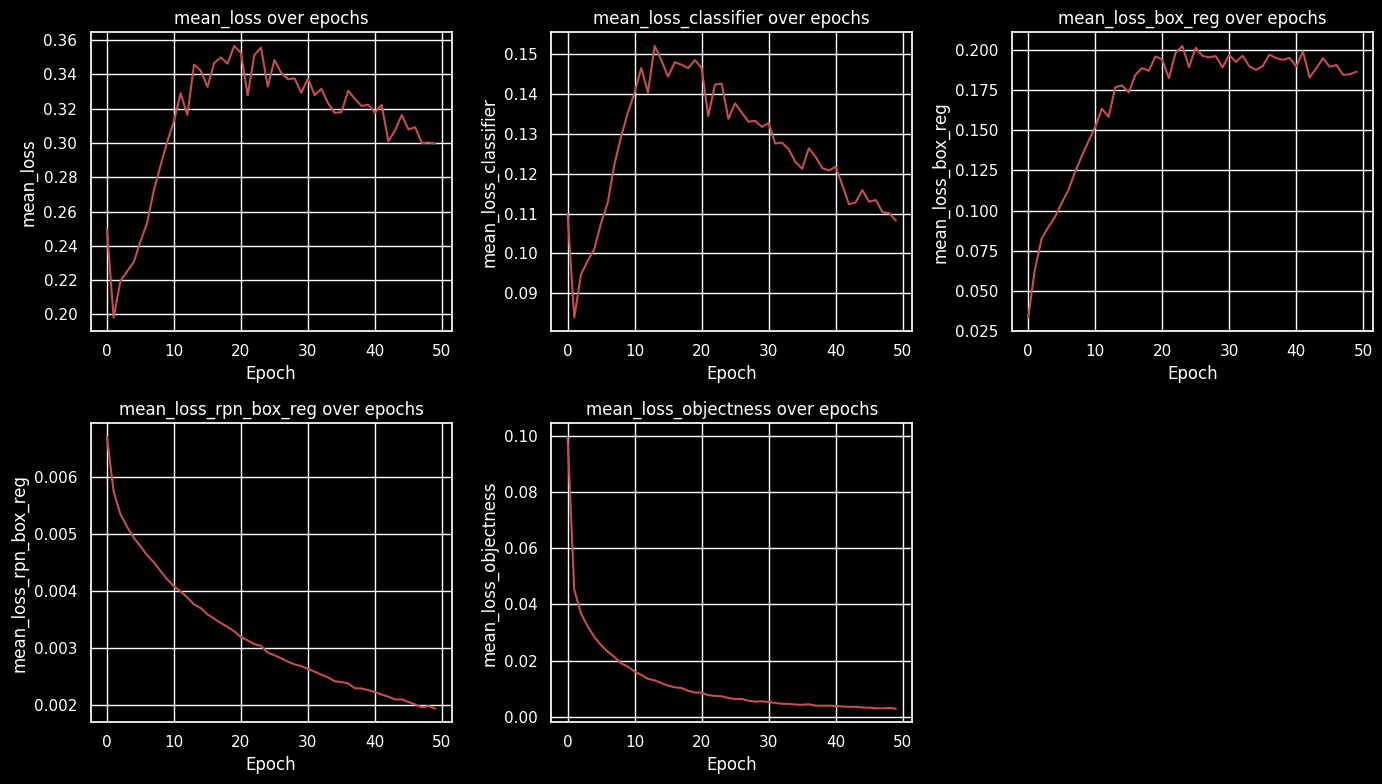

<Figure size 640x480 with 0 Axes>

In [125]:
import seaborn as sns 
# Visualize results
col = trainInfoDataFrame.columns

# Set the style for the plots
plt.style.use("dark_background")

# Plot each of the columns in trainInfoDataFrame
plt.figure(figsize=(14, 8))
for i, column in enumerate(col, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=trainInfoDataFrame[column], c='r')
    plt.title(f'{column} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel(column)

plt.tight_layout()
plt.show()
plt.savefig('trainInfo.png')

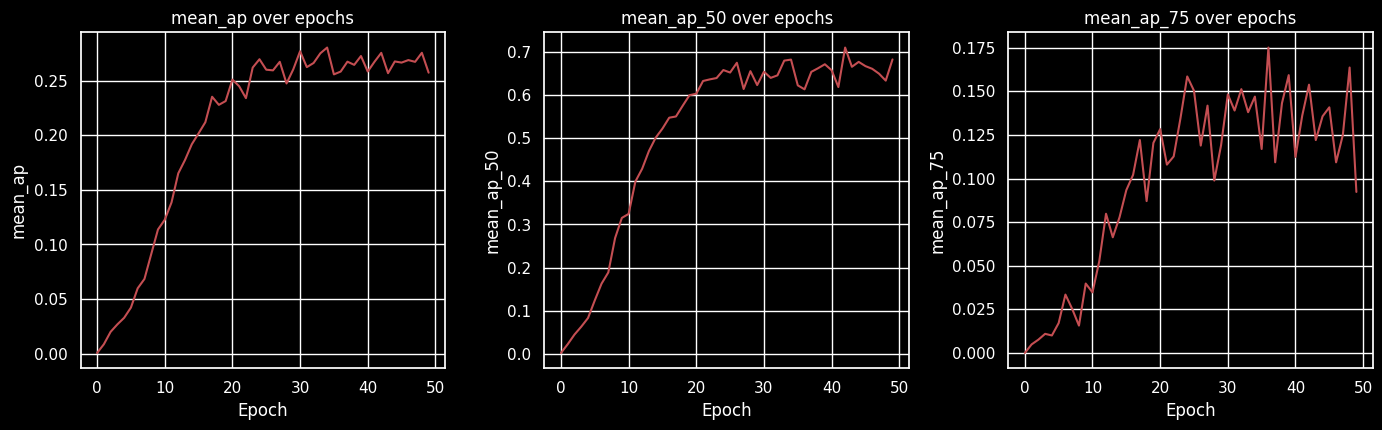

<Figure size 640x480 with 0 Axes>

In [127]:
# Visualize results
col = validInfoDataFrame.columns

# Set the style for the plots
plt.style.use("dark_background")

# Plot each of the columns in validInfoDataFrame
plt.figure(figsize=(14, 8))
for i, column in enumerate(col, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=validInfoDataFrame[column], c='r')
    plt.title(f'{column} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel(column)

plt.tight_layout()
plt.show()
plt.savefig('validInfo.png')

In [146]:
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
def show_bbox_results(model, images, device,savefig , score_threshold=0.5):
    model.to(device)
    model.eval()

    transform = T.ToTensor()
    images_tensor = [transform(image).unsqueeze(0).to(device) for image in images]
    
    with torch.no_grad():
        predictions = [model(image_tensor)[0] for image_tensor in images_tensor]
    
    # Prepare images with bounding boxes
    img_results = []
    for i, prediction in enumerate(predictions):
        boxes = prediction['boxes']
        labels = prediction['labels']
        scores = prediction['scores']

        # Filter out low-confidence detections
        selected_indices = scores > score_threshold
        boxes = boxes[selected_indices]
        labels = labels[selected_indices]
        scores = scores[selected_indices]

        # Convert the image to uint8
        img_tensor_uint8 = (images_tensor[i].squeeze(0) * 255).byte().cpu()

        # Convert labels to strings
        labels_str = [str(label.item()) for label in labels]

        # Draw bounding boxes
        img_with_boxes = draw_bounding_boxes(img_tensor_uint8, boxes, labels=labels_str, colors="red")
        img_results.append(img_with_boxes)

    # Plot the images with bounding boxes
    plt.figure(figsize=(18, 6))
    for i, img_result in enumerate(img_results):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_result.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.savefig(savefig)
    plt.show()

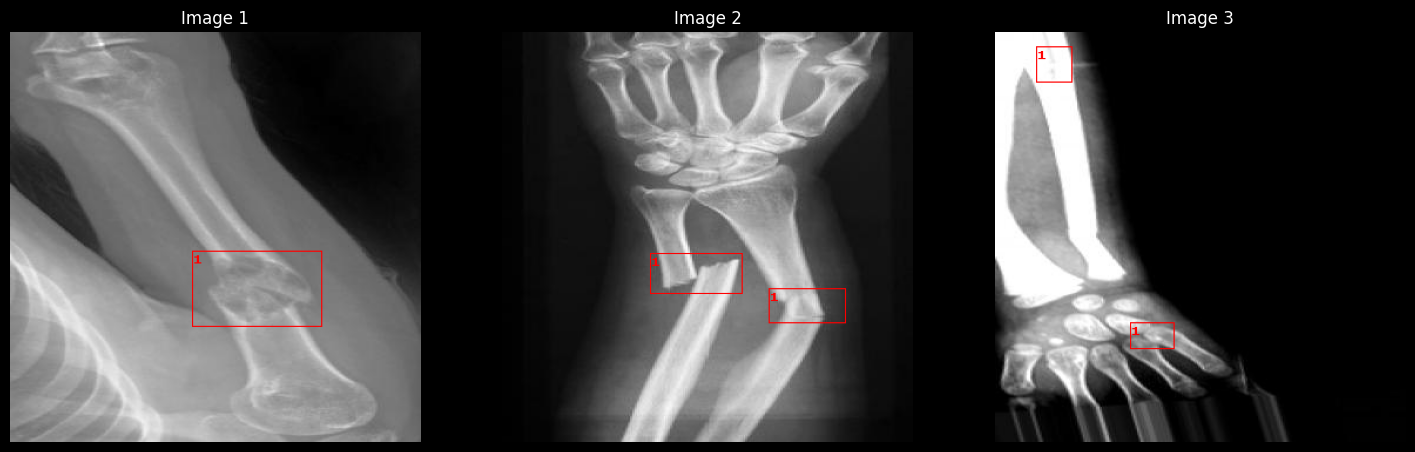

In [148]:
images = [Image.open(os.path.join(test_path ,x)) for x in os.listdir(test_path)[:3]]
show_bbox_results(model=model , device=config['DEVICE'] , images=images  , savefig=os.path.join('/kaggle/working' , 'save'))

In [149]:
# save model 
torch.save(model.state_dict(), 'fasterrcnn_model.pth')